# Description

As a first step, we need to explore and preprocess our data. The goal of this step is to prepare the data for applying clustering algorithms. The dataset contains metadata for 45,000 movies. It consists of movies released on or before July 2017. Data points include title, posters, backdrops, budget, revenue, release dates, languages, description, production countries, and companies from movies_metadata.csv, as well as information about cast and crew from credits.csv.

Source: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

# Import libraries

In [42]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import PCA

plt.style.use('ggplot')
plt.close('all')

In [43]:
# This is done to avoid seeing warnings in Jupyter Notebook

import warnings
warnings.filterwarnings('ignore')

# Basic exploration and preprocessing

In [44]:
# load and check a few rows of movies metadata

df = pd.read_csv('../data/raw_data/movies_metadata.csv')

df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


We see a lot of attributes that describe the movie. In this project, we are going to apply clustering algorithms on the text data of the movie (overview), but to obtain clearer clusters, we will also use the film’s genre. Therefore, from this file, we basically need three columns: overview, genres, and title.

In [45]:
# leave the necessary columns

df = df[['overview', 'genres', 'original_title']]

df.head()

,overview,genres,original_title
0,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Toy Story
1,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Jumanji
2,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Waiting to Exhale
4,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",Father of the Bride Part II


We see that the column genres is a list of dictionaries with IDs and names of genres. So we need to clean it and leave only the list of genre names.

In [46]:
# cleaning the column of genres

def get_genres( item ):

    item = eval(item)  
    result = list( map( lambda x: x['name'], item ) )

    if result == []:
        return np.nan

    return result
    

df['genres'] = df['genres'].apply( get_genres )

In [47]:
df.head()

,overview,genres,original_title
0,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]",Toy Story
1,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]",Jumanji
2,A family wedding reignites the ancient feud be...,"[Romance, Comedy]",Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]",Waiting to Exhale
4,Just when George Banks has recovered from his ...,[Comedy],Father of the Bride Part II


We already have three columns — overview, genres, and original_title. We also need two important columns that help us create a good recommendation system: actors and film director. These columns are important because people often watch films featuring a famous director or actors they love.

In [48]:
# load and check data about actors and film director of films

actors_director = pd.read_csv('../data/raw_data/credits.csv')

actors_director.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


So again, we have columns containing lists of dictionaries. From the cast column, we need all values where the key is name (the actual name of the actor). From the crew column, we need only the value of name where the key job is Director.

In [49]:
# get actors

def get_actors( item ):

    item = eval(item)  
    result = list( map( lambda x: x['name'], item ) )
    
    if result == []:
        return np.nan
    
    return result


df['actors'] = actors_director['cast'].apply( get_actors )

In [50]:
# get directors 

def get_director( item ):

    item = eval(item)  
    necessary_item = list( filter( lambda x: x['job'] == 'Director', item) )

    if necessary_item == []:
        return np.nan
    
    return necessary_item[0]['name']


df['director'] = actors_director['crew'].apply( get_director )

In [51]:
df.head()

,overview,genres,original_title,actors,director
0,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]",Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]",Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,A family wedding reignites the ancient feud be...,"[Romance, Comedy]",Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]",Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,Just when George Banks has recovered from his ...,[Comedy],Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


Now we have all the columns that we will need for this project.

In [52]:
# check the basic info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overview        44512 non-null  object
 1   genres          43024 non-null  object
 2   original_title  45466 non-null  object
 3   actors          43049 non-null  object
 4   director        44579 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


We see that columns overview, genres, aktors and director have null values, so we need to drop those lines.

In [53]:
# drop lines with null values

df.dropna(axis=0, inplace=True)

The column overview has null values, which are marked in the text and have no description. 

In [54]:
no_overview = [ 'No overview found.', 'No overview yet.', 'No Overview', 'No movie overview available.', 'No plot overview available' ]
df = df[ ~df['overview'].isin(no_overview) ]

In [55]:
# check data info after cleaning

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39774 entries, 0 to 45463
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overview        39774 non-null  object
 1   genres          39774 non-null  object
 2   original_title  39774 non-null  object
 3   actors          39774 non-null  object
 4   director        39774 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


# Text preprocessing

So we have the necessary data columns without null values. Now we need to prepare our text data. It contains: unify text, leave only alphabetic symbols, remove unnecessary spaces, tokenization, remove stop words, stemming.

In [56]:
# convert text to lowercase 

df['overview'] = df['overview'].str.lower()

In [57]:
# text cleaning 

def clean( text ):

    text = text.strip()

    available_symbols = "abcdefghijklmnopqrstuvwxyz "
    cleaned_text = [s for s in text if s in available_symbols]
    cleaned_text = ''.join(cleaned_text)
    
    while '  ' in cleaned_text:
        cleaned_text = cleaned_text.replace('  ', ' ')
    
    return cleaned_text


df['overview'] = df['overview'].apply( clean )

In [58]:
# tokenization and removing stop words

def remove_stop_words( text, sw ):

    tokens = text.split()
    tokens = [ token for token in tokens if token not in sw ]

    return tokens


sw = stopwords.words('english')
df['overview'] = df['overview'].apply( lambda text: remove_stop_words( text, sw ) )

In [59]:
# stemming

def stem( tokens, stemmer ):

    return [ stemmer.stem( token ) for token in tokens ]


stemmer = PorterStemmer()
df['overview'] = df['overview'].apply( lambda tokens: stem( tokens, stemmer ))

In [60]:
# check text data

df.head()

,overview,genres,original_title,actors,director
0,"[led, woodi, andi, toy, live, happili, room, a...","[Animation, Comedy, Family]",Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,"[sibl, judi, peter, discov, enchant, board, ga...","[Adventure, Fantasy, Family]",Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,"[famili, wed, reignit, ancient, feud, nextdoor...","[Romance, Comedy]",Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,"[cheat, mistreat, step, women, hold, breath, w...","[Comedy, Drama, Romance]",Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,"[georg, bank, recov, daughter, wed, receiv, ne...",[Comedy],Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


# Text data analysis

We already have cleaned our text data, so we need to explore basic information about them.

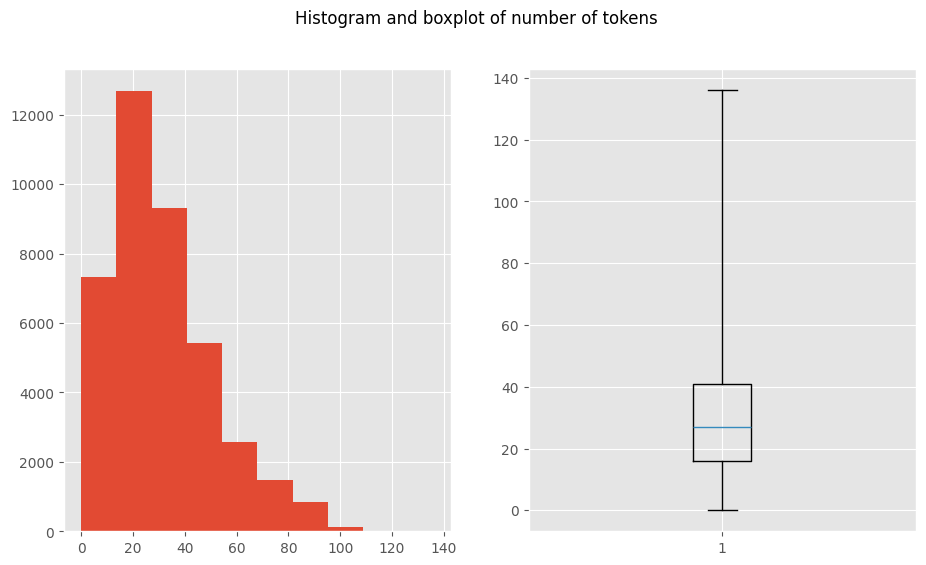

In [61]:
# count tokens histogram and boxplot 

count_tokens = df['overview'].apply( lambda tokens: len( tokens ) )


plt.figure( figsize=(11, 6) )
plt.suptitle('Histogram and boxplot of number of tokens')

plt.subplot(1, 2, 1)
plt.hist( count_tokens )

plt.subplot(1, 2, 2)
plt.boxplot( count_tokens, whis=(0,100) )

plt.show()

We see that the median is ~27 tokens, and the majority of data has a count of tokens between 0 and 60. So we will observe in the feature how it influences clustering and whether this number of words in the film description will be sufficient to break down the data into clear clusters.

In [64]:
# number of unique words

texts = df['overview'].values.tolist()

unique_words = set()
for text in texts:
    for word in text:
        unique_words.add( word )

print(f'Number of unique words in data: {len(unique_words)}')

Number of unique words in data: 60661


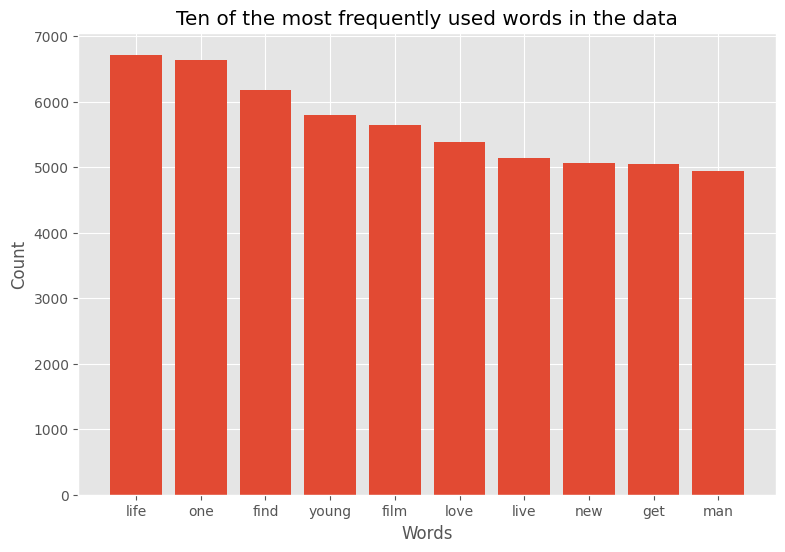

In [65]:
# top 10 most frequently used words

words_dictionary = {}

for text in texts:
    for word in text:

        if word not in words_dictionary:
            words_dictionary[word] = 0

        words_dictionary[word] += 1

sorted_words = sorted( words_dictionary.items(), key=lambda x: x[1], reverse=True )
most_frequently = dict(sorted_words[:10])

plt.figure( figsize=(9, 6) )
plt.bar(most_frequently.keys(), most_frequently.values())
plt.title('Ten of the most frequently used words in the data')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()


We see that the most frequent words don't give general information about the film; all of them are words that can appear in any film description. So in the vectorization step, using TfidfVectorizer will be better than the common CountVectorizer.

# Analysis of other columns

We have analyzed the overview column, so we are going to analyze the other columns — genres, actors, and director.

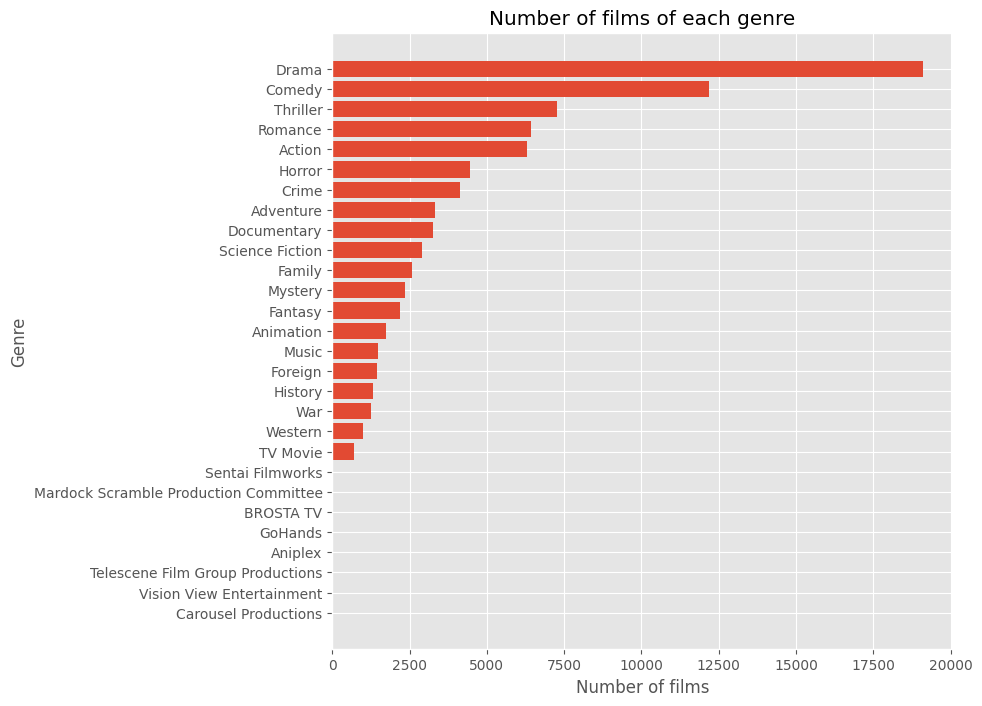

In [66]:
# number of films of each genre

genres_dictionary = {}

for genres in df['genres'].values:
    for genre in genres:

        if genre not in genres_dictionary:
            genres_dictionary[genre] = 0

        genres_dictionary[genre] += 1

sorted_genres = dict( sorted( genres_dictionary.items(), key=lambda x: x[1]) )

plt.figure( figsize=(8, 8) )
plt.barh( sorted_genres.keys(), sorted_genres.values() )
plt.xlabel('Number of films')
plt.ylabel('Genre')
plt.title('Number of films of each genre')
plt.show()

We see that the most frequent genres are drama and comedy, so we can expect that recommendations for films from these genres will work well. We also see that the data contain 8 genres that are not actual genres, so for now, we will not delete the lines with these genres; we will see whether this causes any problems during modeling or not.

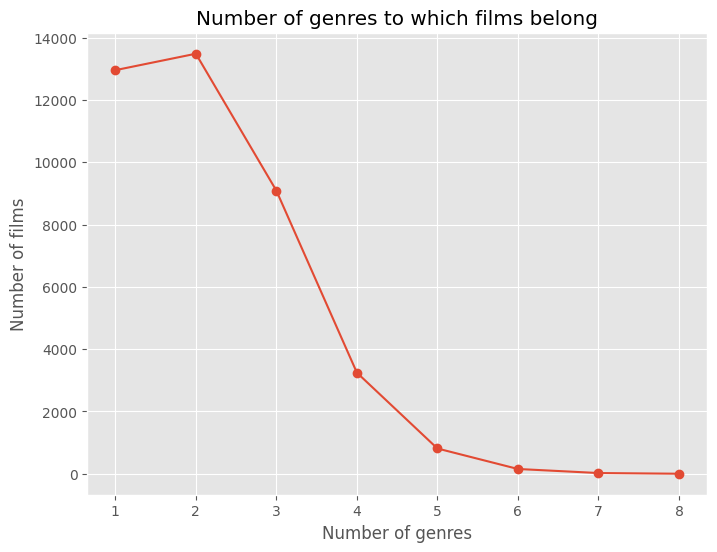

In [67]:
# number of genres to which films belong 

number_genres = df['genres'].apply( lambda x: len(x) )
number_genres = number_genres.value_counts().sort_index()

plt.figure( figsize=(8, 6) )
plt.plot( number_genres.index, number_genres.values, marker='o' )
plt.xlabel('Number of genres')
plt.ylabel('Number of films')
plt.title('Number of genres to which films belong')
plt.show()

We see that many films belong to 2, 3, or 4 genres, so we expect that clusters will be not very clear.

In [68]:
# number of unique directors

directors = df['director'].values.tolist()
print(f'Number of unique directors: {len(set(directors))}')

Number of unique directors: 15613


In [69]:
# number of unique actors

actors = df['actors'].values.tolist()

unique_actors = set()
for actor_list in actors:
    for actor in actor_list:
        unique_actors.add( actor )

print(f'Number of unique actors: {len(unique_actors)}')

Number of unique actors: 194165


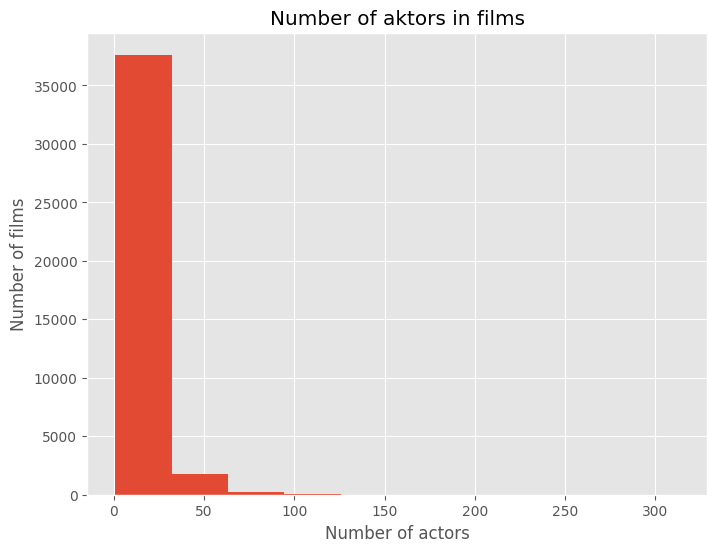

In [71]:
# number of actors in films

number_actors = df['actors'].apply( lambda x: len(x) )

plt.figure( figsize=(8, 6) )
plt.hist( number_actors )
plt.xlabel('Number of actors')
plt.ylabel('Number of films')
plt.title('Number of aktors in films')
plt.show()

We see that the director and actors columns have a lot of unique values, but each film has only one director, and nearly all films have fewer than 50 actors. We are going to encode these columns with CountVectorizer, so using dimensionality reduction will be necessary.

# Text vectorization

Before applying any machine learning algorithms, we should convert our text data to numbers. Based on the previous analysis, we are going to use TfidfVectorizer, which takes into account the frequency of words in the data.

In [72]:
# vectorization of text

vectorizer = TfidfVectorizer()
vec_text_data = vectorizer.fit_transform( df['overview'].apply( lambda x: ' '.join(x) ) )

In [73]:
print(f'Shape of vectorizated text: {vec_text_data.shape}' )

Shape of vectorizated text: (39774, 60642)


# Coding of other columns

We are going to encode other columns (genres, actors, and director) using CountVectorizer, where each column will indicate whether, for example, a particular actor is in a film or not.

In [74]:
# preparing columns before joining

def remove_spaces(item):

    if type(item) == str:  # for column director
        item = [item]

    new_item = []
    for el in item:
        el = el.split(' ')
        new_item.append( ''.join(el) )

    return new_item


df['genres'] = df['genres'].apply( remove_spaces )
df['actors'] = df['actors'].apply( remove_spaces )
df['director'] = df['director'].apply( remove_spaces )

In [75]:
# joining columns 

df['genres_actors_director'] = df['genres'] + df['actors'] + df['director']
df['genres_actors_director'] = df['genres_actors_director'].apply( lambda x: ' '.join( x ) )

In [76]:
df[['genres_actors_director']].head()

,genres_actors_director
0,Animation Comedy Family TomHanks TimAllen DonR...
1,Adventure Fantasy Family RobinWilliams Jonatha...
2,Romance Comedy WalterMatthau JackLemmon Ann-Ma...
3,Comedy Drama Romance WhitneyHouston AngelaBass...
4,Comedy SteveMartin DianeKeaton MartinShort Kim...


In [77]:
# coding of obtained column

coder = CountVectorizer()
coded_data = coder.fit_transform( df['genres_actors_director'] )

In [78]:
print(f"Shape of coded data: {coded_data.shape}")

Shape of coded data: (39774, 207750)


# Reduction of dimensionality

Now we have matrices with huge shapes, having more features than data lines. So we need to reduce dimensionality before applying clustering algorithms. We are going to use one of the most common methods — PCA (Principal Component Analysis).

In [79]:
# concatenate of matrices

data = hstack([vec_text_data, coded_data])
print(f'Shape of concatenated data: {data.shape}')

Shape of concatenated data: (39774, 268392)


In [80]:
# applying reduction of dimensionality

pca = PCA( n_components=50 ).set_output(transform='pandas')
reduced_data = pca.fit_transform( data )

In [81]:
# add a title column for future using

reduced_data['title'] = df['original_title'].values

In [82]:
reduced_data.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,title
0,-0.881528,0.435086,-0.002348,0.138545,-0.309979,0.291043,0.780108,-0.089343,-0.051965,-0.122346,...,0.011067,0.135440,0.009302,-0.135259,-0.036759,0.005865,0.067443,-0.064825,-0.041612,Toy Story
1,-0.457887,-0.246543,-0.383760,0.678759,0.137287,0.531431,1.132837,0.027701,-0.023152,-0.259651,...,0.008981,0.044314,0.001732,-0.058217,-0.010985,-0.039142,0.024793,-0.002603,-0.003757,Jumanji
2,-0.638993,0.768074,0.256022,-0.220891,0.599786,-0.242320,-0.001552,0.013555,-0.030947,-0.016190,...,0.012393,0.112254,0.004677,-0.051300,0.010108,0.065319,0.077499,0.025520,0.008961,Grumpier Old Men
3,0.204259,1.059727,0.399481,-0.159060,0.403462,-0.023763,-0.074642,-0.039762,-0.046848,0.019834,...,-0.022144,-0.005580,0.004474,-0.005043,0.009631,-0.029076,-0.005324,0.011358,-0.003998,Waiting to Exhale
4,-0.740343,0.416806,0.105290,-0.133184,-0.273028,-0.025288,-0.077700,-0.073439,-0.026090,0.005135,...,0.064017,0.088048,-0.011469,-0.040830,-0.090784,0.002157,0.020374,-0.035388,0.074111,Father of the Bride Part II


In [83]:
# save preprocessed data

reduced_data.to_csv('../data/preprocessed_data.csv', index=False)